Check GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  2 02:02:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Load Google Drive 

In [ ]:
from google.colab import drive #Only if you are using Google Drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/My\ Drive/

Mounted at /content/gdrive
Mounted at /content/gdrive
/content/gdrive/My Drive


Location of spectograms for home location, small sample testing

In [ ]:
cd /content/gdrive/MyDrive/urbansound/spectograms/protosound/dataset

/content/gdrive/MyDrive/urbansound/spectograms/protosound/dataset


**Model**

Check folders

Dataset for protosound only

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

#training_dir = '/content/gdrive/MyDrive/urbansound/spectograms/protosound/dataset/train'
training_dir = '/content/gdrive/MyDrive/content/img_dir/train/'
#validation_dir = '/content/gdrive/MyDrive/content/img_dir/us8k_freesound/all_labeled/'
validation_dir = '/content/gdrive/MyDrive/content/img_dir/test/'
test_dir = '/content/gdrive/MyDrive/content/img_dir/test/'

folders = glob(training_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

print ('Total Classes = ' + str(num_classes))
print('Total training classes '+str(len(glob(training_dir + '/*'))))
print('Total test classes '+str(len(glob(test_dir + '/*'))))
print('Toral validation classes '+str(len(glob(validation_dir + '/*'))))

Total Classes = 10
Total Classes = 10
Total training classes 10
Total test classes 10
Toral validation classes 10


Import Libraries

In [ ]:
# importing requried libraries
%tensorflow_version  1.x
from keras import applications
from keras.models import Model
import keras 
from keras.applications.vgg16 import VGG16 #Importing the VGG16 Model
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from keras.applications import VGG16, MobileNetV2
from keras.optimizers import SGD
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input  

import os
import PIL
import time
import datetime
import PIL.Image as Image

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Data pre-processing**

In [ ]:
# 255 batch size
IMAGE_SIZE = [224,224]
BATCH_SIZE = 32

training_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=40, 
                                      width_shift_range=0.3, height_shift_range=0.3, 
                                      shear_range=0.3, horizontal_flip=True, fill_mode="nearest",
                                      preprocessing_function=preprocess_input,
                                      samplewise_center=True, samplewise_std_normalization=True)
training_generator = training_datagen.flow_from_directory(directory=training_dir,
                                                          target_size = IMAGE_SIZE, 
                                                          batch_size = BATCH_SIZE, 
                                                          class_mode = 'categorical')
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                        samplewise_center=True, 
                                        samplewise_std_normalization=True)
validation_generator = validation_datagen.flow_from_directory(directory=test_dir, 
                                                              target_size = IMAGE_SIZE, 
                                                              batch_size = BATCH_SIZE, 
                                                              class_mode = 'categorical')
training_generator.class_indices


Found 6969 images belonging to 10 classes.
Found 1747 images belonging to 10 classes.


{'air_conditioner': 0,
 'car_horn': 1,
 'children_playing': 2,
 'dog_bark': 3,
 'drilling': 4,
 'engine_idling': 5,
 'gun_shot': 6,
 'jackhammer': 7,
 'siren': 8,
 'street_music': 9}

Load VGG16, add extra layer and compile

In [ ]:
vgg_model = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  

for layer in vgg_model.layers:
      layer.trainable = False # Non trainable weights

# Create Dense Layers
# Add the last layers (Flatten and Dense layers) for our problem
x = Flatten()(vgg_model.output) 
x = Dense(num_classes, activation = 'softmax')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting

transfer_model = Model(inputs = vgg_model.input, outputs = x)
# Compile model, for this we will be using ADAM optimiser to reach to the global minima while training our model
# learning_rate= 5e-5
transfer_model.compile(loss="categorical_crossentropy", 
                       optimizer='adam', 
                       metrics=['accuracy'])
#history = transfer_model.fit(X_train, y_train, batch_size = 1, epochs=50, validation_data=(X_test,y_test))

#transfer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
transfer_model.summary() #check summary of the model using this command


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# 6969 images, 32 batch size 
history = transfer_model.fit_generator(training_generator,
                   steps_per_epoch =218, #Number of iterations = number of training images (6969) / batch size (32)  
                   epochs = 10, 
                   validation_data = validation_generator,
                   validation_steps = 2, #same for validation data 300 validation images
                   shuffle = True)
transfer_model.save('/content/gdrive/MyDrive/final/vgg16_us8k_spp218_10ep.h5')

Epoch 1/10
218/218 [==============================] - 2353s 11s/step - loss: 1.4260 - accuracy: 0.1241 - val_loss: 1.1921e-07 - val_accuracy: 0.0781
Epoch 2/10
218/218 [==============================] - 94s 432ms/step - loss: 1.1921e-07 - accuracy: 0.1145 - val_loss: 1.1921e-07 - val_accuracy: 0.1406
Epoch 3/10
218/218 [==============================] - 94s 433ms/step - loss: 1.1921e-07 - accuracy: 0.1145 - val_loss: 1.1921e-07 - val_accuracy: 0.1250
Epoch 4/10
218/218 [==============================] - 93s 427ms/step - loss: 1.1921e-07 - accuracy: 0.1145 - val_loss: 1.1921e-07 - val_accuracy: 0.0938
Epoch 5/10
218/218 [==============================] - 93s 427ms/step - loss: 1.1921e-07 - accuracy: 0.1145 - val_loss: 1.1921e-07 - val_accuracy: 0.0938
Epoch 6/10
218/218 [==============================] - 92s 424ms/step - loss: 1.1921e-07 - accuracy: 0.1145 - val_loss: 1.1921e-07 - val_accuracy: 0.1250
Epoch 7/10
218/218 [==============================] - 91s 418ms/step - loss: 1.1921e-0

In [ ]:
transfer_model.save('/content/gdrive/MyDrive/content/models/final/vgg16_us8k_spp218_10ep_11pct_accuracy.h5')

In [ ]:
transfer_model.save('/content/gdrive/MyDrive/content/models/final/vgg16_us8k_spp218_10ep_11pct_accuracy')

In [ ]:
validation_steps = 20
loss0,accuracy0 = transfer_model.evaluate(validation_generator, steps = validation_steps)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 3s 166ms/step
loss: 0.00
accuracy: 0.11


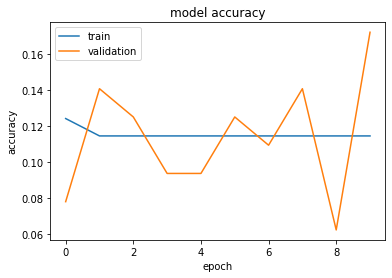

In [ ]:
#learning curves
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

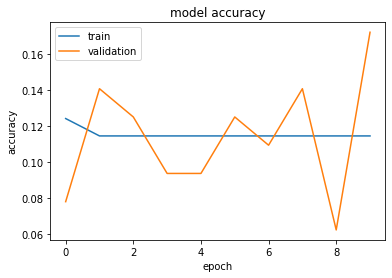

In [ ]:
#learning curves
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

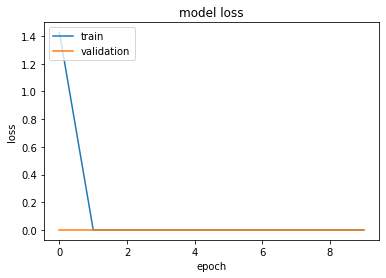

In [ ]:

#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,Activation,MaxPooling2D,Dense,Flatten,Dropout
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
Y_pred = transfer_model.predict_generator(validation_generator) #, steps=4500 // batchsize+1)
#validation_generator
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())   
report = classification_report(target_names, y_pred, target_names=class_labels)
print(report) 

Confusion Matrix
[[200   0   0   0   0   0   0   0   0   0]
 [ 86   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0]
 [ 75   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0]
 [186   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0]]
Classification Report
                  precision    recall  f1-score   support

 air_conditioner       0.11      1.00      0.21       200
        car_horn       0.00      0.00      0.00        86
children_playing       0.00      0.00      0.00       200
        dog_bark       0.00      0.00      0.00       200
        drilling       0.00      0.00      0.00       200
   engine_idling       0.00      0.00      0.00       200
        gun_shot       0.00      0.00      0.00        75
      jackhammer       0.00      0.00      0.00       200
       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#from keras.models import load_model
#model = load_model('/content/gdrive/MyDrive/final/AED_TeslaP100_vgg16_full_1082_Param.h5')

In [ ]:
#!pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
def show_confusion_matrix(test_labels, predictions):
  """Compute confusion matrix and normalize."""
  confusion = sk_metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), predictions)
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = list(CLASSES.values())
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(batch_labels, test_prediction)

NameError: ignored

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False)

Found 1747 images belonging to 10 classes.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
#Y_pred = transfer_model.predict(test_generator, test_generator.samples // test_generator.batch_size)
Y_pred = transfer_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Bark', 'Jump', 'Stand','Walk']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix


NameError: ignored

Model Testing

In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
import numpy as np
import os
img_size = 224
dir_loc ='/content/gdrive/MyDrive/content/img_dir/us8k_freesound/test/'
clssN = os.listdir(dir_loc)
count = 0
countT = 0
for bl in clssN:
  src = dir_loc + bl 
  imgs = os.listdir(src)
  count = 0
  countT = len(imgs) #total number of images per class
  for img in imgs: 
    im = load_img(src + "/" + img)
    w,h = im.size
    im = im.resize((int(w*0.2),int(h*0.2)))
    im = im.resize((img_size,img_size))
    x = img_to_array(im)  
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x/=255.
    probs = transfer_model.predict(x, verbose=0)
    maxDet = max(probs[0])
    maxIdx = list(probs[0]).index(maxDet) #predicted class with maximum probability
    if (clssN[maxIdx]==bl): 
      count = count + 1  #count for true predictions (true positives)
    else:
      print(f'Wrong prediction of {bl}  {img}. Predicted as {clssN[maxIdx]}') 
  print(f'test accuracy for {bl} is {str(count/countT)}')

ValueError: ignored

Using the below code, you will see the output of what building class the model has predicted for this specific image.

Plotting loss and accuracy

KeyError: ignored

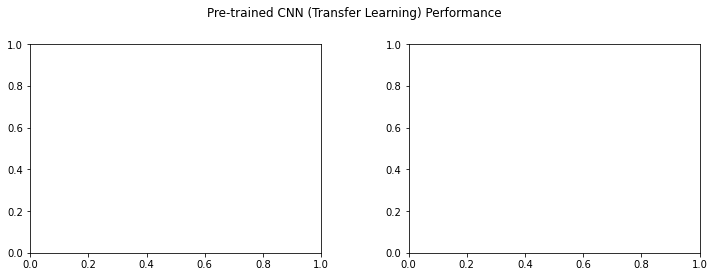

In [ ]:
#import matplotlib as plt
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")